<a href="https://colab.research.google.com/github/AliceKitchkin/Unsupervised-Machine-Learning/blob/main/AirlinePassengerSatisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Bibliotheken und Daten Import

---

In [ ]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import StandardScaler

# pca
from sklearn.decomposition import PCA

# clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# evaluations
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_raw = pd.read_csv("/content/drive/MyDrive/Bachelorarbeit/CSV/Airline Passenger Satisfaction/AirlinePassengerData_Test.csv")
data = data_raw.copy()

#2. Aufbereitung

---

##2.1 First Look

In [ ]:
data_raw.head(5)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

##2.2 Missing Values

Missingno is a Python library that provides the ability to understand the distribution of missing values through informative visualizations.

In [ ]:
print(data_raw.isna().sum())
print("\n")
print(data_raw.isnull().sum())

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


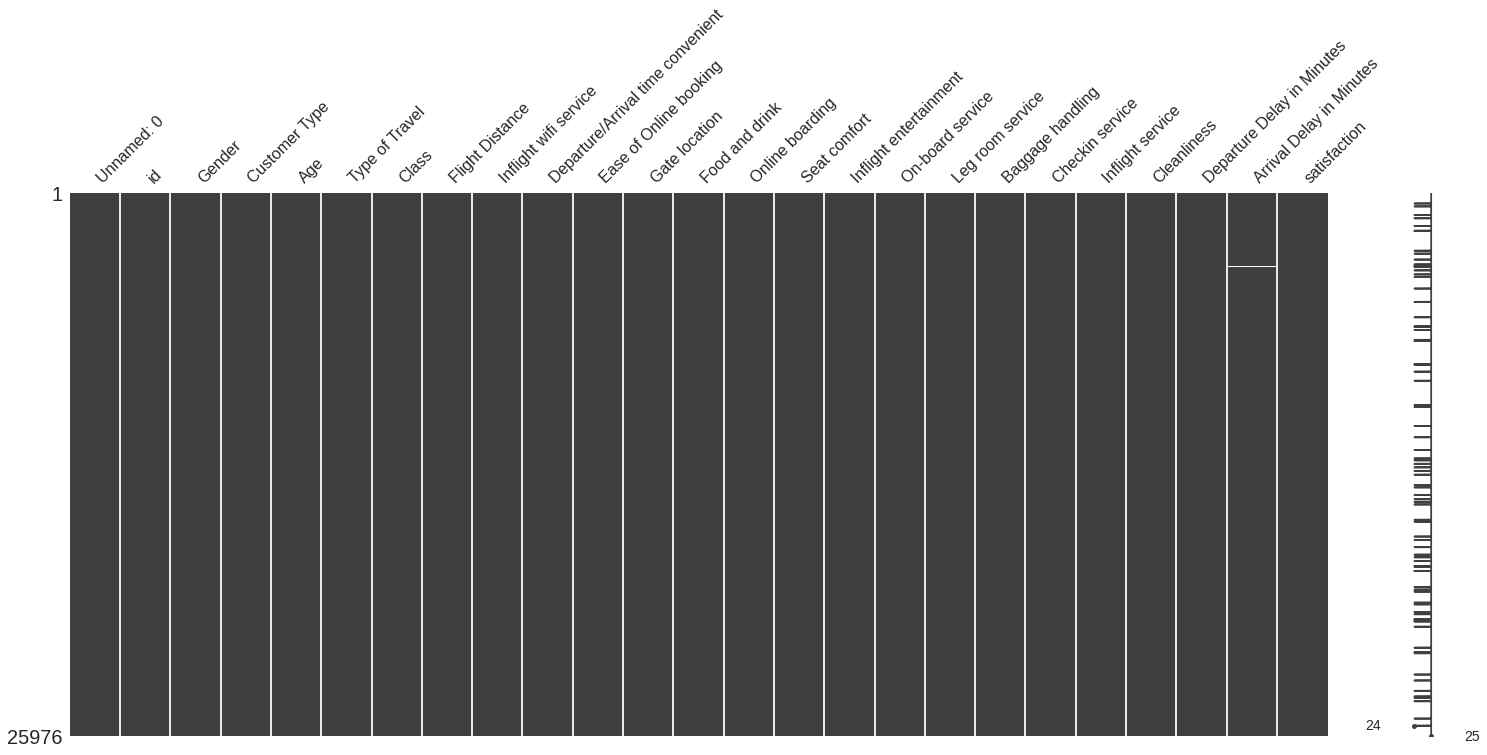

In [ ]:
msno.matrix(data_raw)

Die Spalte "Arrival Delay in Minutes" (Verspätung in Minuten) hat 83 fehlende Werte.

##2.3 Spaltenaufarbeitung

In [ ]:
#Neue Spalte "Gesamtverspaetung in Minuten" hinzufügen
data['Gesamtverspaetung in Minuten'] = data['Departure Delay in Minutes'] + data['Arrival Delay in Minutes']

In [ ]:
#Neue Spalte "Bewertung Gesamt" hinzufügen
data['Bewertung Gesamt'] = data['Inflight wifi service'] + data['Departure/Arrival time convenient'] + data['Ease of Online booking'] + data['Gate location'] + data['Food and drink'] + data['Online boarding'] + data['Seat comfort'] + data['Inflight entertainment'] + data['On-board service'] + data['Leg room service'] + data['Baggage handling'] + data['Checkin service'] + data['Inflight service'] + data['Cleanliness']

In [ ]:
#Erste Spalte "Unnamed: 0" löschen, ist bloß ein Zeilenzähler
data = data.drop("Unnamed: 0", axis=1)

In [ ]:
#Die Spalte "satisfaction" in 0 und 1 umwandeln
data['satisfaction'] = data['satisfaction'].replace({'satisfied':1, 'neutral or dissatisfied':0})

In [ ]:
#Die Spalte "Ist Kind" erstellen
data['Ist Kind'] = np.where(data.Age<13 , 1, 0)

In [64]:
#Die Spalte "Ist Erwachsener" erstellen
data['Ist Erwachsener'] = np.where(data.Age>=18 , 1, 0)

In [65]:
#Die Spalte "Ist Teenager" erstellen
data['Ist Kind'] = np.where((data.Age>12) & (data.Age<18), 1, 0)

In [68]:
#Die Spalte "Gender" in m und f umwandeln
data['Gender'] = data['Gender'].replace({'Female':'f', 'Male':'m'})

In [70]:
data.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Gesamtverspaetung in Minuten,Bewertung Gesamt,Ist Kind,Ist Erwachsener
0,19556,f,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,1,94.0,58,0,1
1,90035,f,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,1,0.0,48,0,1
2,12360,m,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,0,0.0,30,0,1
3,77959,m,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,1,6.0,25,0,1
4,36875,f,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,1,20.0,37,0,1


#3. XXX

---